In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split

In [237]:
# 1. 데이터 불러오기 및 날짜 필터링
df = pd.read_csv("C:/Users/jinwo/Downloads/AAME.csv")
df = df.dropna()
df = df[df['Open'] != 0]  # 0인 행 제거
df

,Date,Open,High,Low,Close,Adj Close,Volume
66,1980-06-19,3.80,3.80,3.80,3.80,3.171437,0
71,1980-06-26,3.50,3.50,3.50,3.50,2.921061,0
72,1980-06-27,3.50,3.50,3.50,3.50,2.921061,0
118,1980-09-03,4.60,4.60,4.60,4.60,3.839107,0
194,1980-12-22,5.25,5.25,5.25,5.25,4.381591,0
...,...,...,...,...,...,...,...
10093,2020-03-26,2.29,2.29,2.08,2.28,2.280000,1600
10094,2020-03-27,2.25,2.25,2.21,2.25,2.250000,500
10095,2020-03-30,2.25,2.25,2.13,2.13,2.130000,400
10096,2020-03-31,2.11,2.11,2.11,2.11,2.110000,300


In [239]:
# 2. 특징값 선택 및 정규화
features = ['Open', 'High', 'Low', 'Close']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

In [241]:
# 3. 다변량 시퀀스 생성 함수 정의
def make_multivariate_io(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])        # shape: (window, features)
        y.append(data[i+window][-1])       # Close 값 예측 (index=3)
    return np.array(X), np.array(y)

In [243]:
# 4. 시퀀스 생성 및 train/test 분할
window_size = 7
X, y = make_multivariate_io(X_scaled, window_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6815, 7, 4), (1704, 7, 4), (6815,), (1704,))

In [245]:
# 5. RNN 모델 구성
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(window_size, 4)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

C:\Users\jinwo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)            │ (None, 64)                  │           4,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

In [247]:
# 6. 모델 학습
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# 7. 예측
y_pred = model.predict(X_test)

# 8. MSE 출력 (정규화된 값 기준)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE (Normalized): {mse:.6f}")

Epoch 1/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0031 - val_loss: 1.0493e-04
Epoch 2/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6864e-04 - val_loss: 9.3036e-05
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4783e-04 - val_loss: 9.5900e-05
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3293e-04 - val_loss: 8.1089e-05
Epoch 5/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6494e-04 - val_loss: 5.8739e-05
Epoch 6/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.4838e-04 - val_loss: 9.3195e-05
Epoch 7/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.5496e-04 - val_loss: 5.8684e-05
Epoch 8/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7645e-04 - val_loss: 8.4787e-05
Epoch 9/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5171e-04 - val_loss: 9.5617e-05
Epoch 10/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8473e-04 - val_loss: 7.8306e-05
Epoch 11/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.

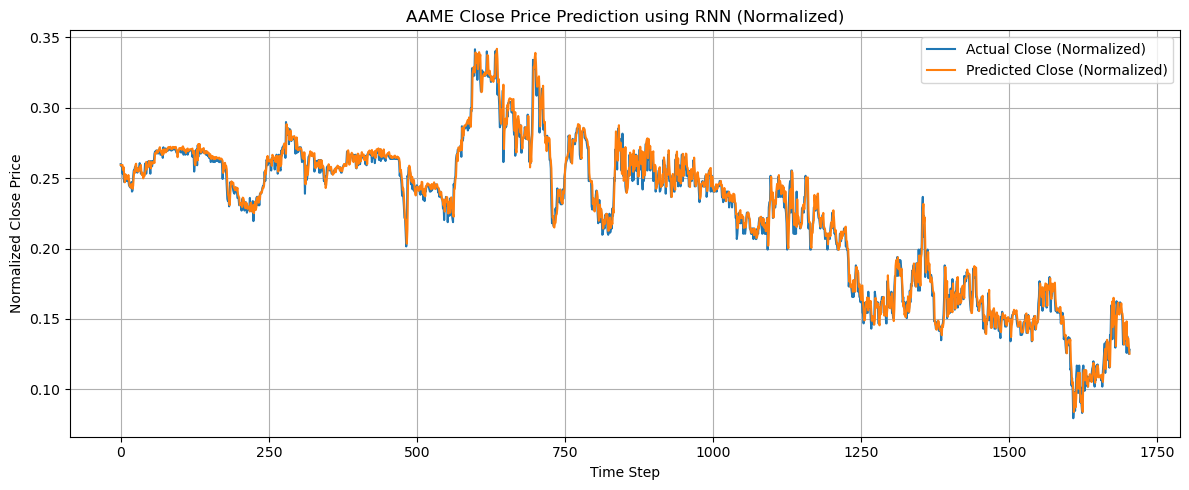

In [253]:
# 10. 결과 시각화 (정규화된 값 기준으로)
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Close (Normalized)')
plt.plot(y_pred, label='Predicted Close (Normalized)')
plt.title('AAME Close Price Prediction using RNN (Normalized)')
plt.xlabel('Time Step')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()